## Studying Bias Variance Tradeoff

We will experiment with a toy regression problem, in which we generate synthetic data (from a known p(x,y)), creating data sets of varying sizes. For each size $N$, we repeat $m$ times the following experiment: 

* draw a data set $(X,y)$ of size $N$
* fit a model (with a given degree $d$ of polynomial fit, and $\lambda$ parameter of ridge regression

Once we are done, we can plot the $m$ models as well as their average; this gives us a visual illustration of the behavior of a particular model family (defined by $d$ and $\lambda$) on data of given size.

We can also analyze the different components that contribute to the (expected, test-time) loss of these models. That's the main contribution you will have to make to the notebook.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
import matplotlib
import math
matplotlib.rcParams.update({'figure.max_open_warning': 0}) # to supress an annoying warning about too many figures

### Definitions for out data generator and related functions

In [14]:
# some utility functions provided by us

def degexpand(X, deg, C=None):
    """
    Prepares data matrix with a column of ones and polynomials of specified
    degree.

    Parameters
    ----------
        X : 2D array
            n x d data matrix (row per example)
        deg : integer
            Degree of polynomial
        C : 1D array
            Scaling weights. If not specifed, weights are calculated to fit each
            columns of X in [-1, 1].
            Note: It is shown in problem set 1 that this normalization does
            not affect linear regression, as long as it is applied
            consistently to training *and* test data.

    Returns
    -------
        out_X : 2D array
            n x (2 * d + 1) data matrix (row per example)
            The output is arranged as follows:
            <see solutions for PS1>
        C : 1D array
            Scaling weights that were used. Can be used in scaling other data later in the same way.
    """
    assert X.ndim == 2
    n, m = X.shape
    # Make polynomials
    out_X = (X[..., np.newaxis] ** (1. + np.arange(deg))).reshape(n, -1)

    # Add column of ones
    out_X = np.concatenate([np.ones((out_X.shape[0], 1)), out_X], axis=1)

    if C is None:
        C = abs(out_X).max(axis=0)
    else:
        assert np.shape(C) == (out_X.shape[1],), "C must match outgoing matrix"

    out_X /= C # divide dimension-wise
    return out_X, C


def gen_samples(fn, domain=(-5,5),num_samples=3, sigma=1.0):
    """
    Main building block for the data generator
    Produce num_samples from p(x,y) where
    x ~ uniform(domain), y|x~fn(x)+nu,  nu~N(0,sigma)
    
    Returns 2D array of shape (num_samples,2)
    """
    low, high = domain

    # sample points
    data = []
    for _ in range(num_samples):
        _input = random.uniform(low, high)
        data.append( [_input, fn(_input)] )
    data = np.array(data)

    # sample some guassian noise
    noise = np.random.normal(loc=0.0, scale=sigma, size=num_samples)
    
    data[:,1] += noise
    
    return data

def gen_train_data(fn, num_samples=3, num_sets=30, domain=(-5,5), sigma=1.0):
    """
    Generate num_sets datasets, each with num_samples points, drawn i.i.d. from
    p(x,y) defined by domain, fn, sigma (see comment for gen_samples)
    
    Returns data of shape (num_sets,num_samples,2) where (:,:,0) are xs and (:,:,1) are ys
    """

    data = np.array([gen_samples(
        fn, num_samples=num_samples, domain=domain, sigma=sigma) for _ in range(num_sets)])
    return data

def gen_val_data(fn, num_samples=100, num_sets=30,domain=(-5,5), sigma=1.0):
    """
    Generate validation data with num_samples drawn i.i.d. from p(x,y)
    where x~uniform(domain), y|x ~ fn(x)+nu, nu~N(0,sigma)
    
    This generates a set of sets, similar to gen_train_data, but for val, we get the same X
    in all the sets, but different ys (varying according to the non-deterministic model component)
    Since we want this property, the code is a bit different from gen_train_data
    """
    
    low, high = domain

    data=np.zeros([num_sets,num_samples,2])
    
    np.random.seed(789123) # fix random number generator seed for consistency; e
                           # very time you run this you should get same val set
                        
    
    # sample values of x (once)
    xs = np.random.uniform(low,high,num_samples)
    Fx = fn(xs) # the deterministic portion of y (shared by all num_sets val sets)
    
    for s in range(num_sets):
        # add random noise (different for each instance in each set)
        noise = np.random.normal(loc=0.0, scale=sigma, size=num_samples)
        data[s,:,:]=np.stack((xs,Fx+noise),axis=1)
    
    # rerandomize. Comment out for deterministic run
    from datetime import datetime
    np.random.seed(int(round(datetime.now().timestamp())))
    
    return data
    

In [15]:
fn = lambda x: -0.02*x**4 + 0.1*x**3 + 0.3*x**2 - 1.2*x
data = gen_samples(fn, num_samples=10)
print(data)

vall = gen_val_data(fn, num_samples=4, num_sets=3)
print("vall is", vall)


[[ 3.41916314  1.41286883]
 [ 0.1203732  -0.77595574]
 [-4.18657233 -3.875309  ]
 [-1.01351909  0.87740795]
 [ 3.19845041 -0.80748571]
 [ 1.11497339  1.08582383]
 [-0.64456161  1.50196654]
 [ 2.10372136  0.20335628]
 [ 3.55726403  2.44527083]
 [ 1.23558201 -0.25663267]]
vall is [[[ 0.7449795   0.42858784]
  [ 0.03480573  1.28416081]
  [-2.96157405  2.17849798]
  [-1.24080415  3.64510604]]

 [[ 0.7449795   0.1875382 ]
  [ 0.03480573 -0.77636879]
  [-2.96157405  2.06078985]
  [-1.24080415  4.6633912 ]]

 [[ 0.7449795  -1.90458006]
  [ 0.03480573  0.97556317]
  [-2.96157405  2.40726966]
  [-1.24080415  1.73928966]]]


### Solving the problem using closed form solution to ridge regreesion

In [16]:
def closed_form_reg_solution(train, lamb, degree): 
    """
    Closed form solution for ridge regression, for a givem regularization parameter 'lamb' and polynomial
    model degree 'degree'
    Expects a set of training sets, and returns a corresponding set of models
    train is of shape (M,N,2) where train(m,:,0) and train(m,:,1) are xs and ys of the m-th set # ask: what is m-th set?

    Fit (train) a model for each set, and return a list of models. Each model is a dictionary:
    'w' -> the model parameters w
    'C' -> the feature scaling coefficients (applied to phi(x) before fitting or deploying the model)
    'deg' -> the polynomial degree (complexity) of the model
    'lambda' -> the regularization parameter for ridge regression
    """
    
    models=[]
    
    for train_data in train:
        # extract x,y from train_data
        x, y = train_data[:,:-1], train_data[:,1].reshape(-1,1)
    
        # map x to (normalized) feature maps
        x, C = degexpand(x, degree)
 
        N, m = x.shape

        I = np.eye(m)
        tmp = np.dot(x.T, x)
        tmp += lamb * I
        
        w = np.linalg.pinv(tmp).dot(x.T).dot(y)
        # numerically stable alternative courtesy of https://stackoverflow.com/a/54772323/6416660
        # w = np.linalg.solve(tmp, x.T.dot(y))

        # record the model
        models.append({'w': w, 'C': C, 'deg': degree, 'lambda': lamb})
        
    return models


### Visualization code

In [17]:
def plot(data, models, domain=(-5,5),ax=None):
    """
    Plot the data set (1D x->y) as blue dots, and the function predicted by each model in the list 'models' 
    as a red line (all the models are used, yielding a "bundle" of lines)
    The average prediction (averaged over the models for every x) is plotted as a cyan line
    """
    
    if ax is None:
        ax=plt.axes()
    
    # sample points along x to interpolate
    x_range = np.linspace(domain[0], domain[-1], 100)
    x_range = x_range.reshape(-1,1)
    mean_y = np.zeros(x_range.shape)
    
    for m in models:
        x_values, _ = degexpand(x_range, m['deg'], m['C']) # =0.5 deg 1, c 2; deg 0. c 3; deg 2, c 4; => (3, 1, 1)
        yhat=np.dot(x_values,m['w'])
        mean_y = mean_y+yhat/len(models)
        ax.plot(x_range, yhat, 'r-', linewidth = 1,alpha=.3)
    if data is not None:
        ax.plot(data[:,0], data[:,1], 'b.',markersize=2)
    ax.plot(x_range,mean_y,'-',c='xkcd:cyan',linewidth=3)
    ax.grid(True)
    ax.set_ylim(-13,5.5)
    ax.set_title("lambda=%.2f" % (m['lambda']))
#     plt.savefig(name+"samp_my_fig")


In [23]:
# function we want to model
fn = lambda x: -0.02*x**4 + 0.1*x**3 + 0.3*x**2 - 1.2*x
# this is an example of Python's "lambda expression" which sort of defines an unnamed function. 
# Try playing with the coefficients, or maybe add terms, to get differently shaped functions
    
# the domain of the function we're sampling from
domain=(-5,5)

# std of the guassian noise to be added
sigma = 0.5

# we will explore these regularization parameters
# lambdas = [0,1.0,50.0]
lambdas = [1]
# and these Ns
Ns = [5,10,25,50,100]

# generate a val set (will be shared in all the experiments)
# make it large to get a meaningful approximation for the test loss
val = gen_val_data(fn, num_sets=1000, num_samples=1000, domain=domain, sigma=sigma) # original 1000 sets


### Model fitting (running the experiment)

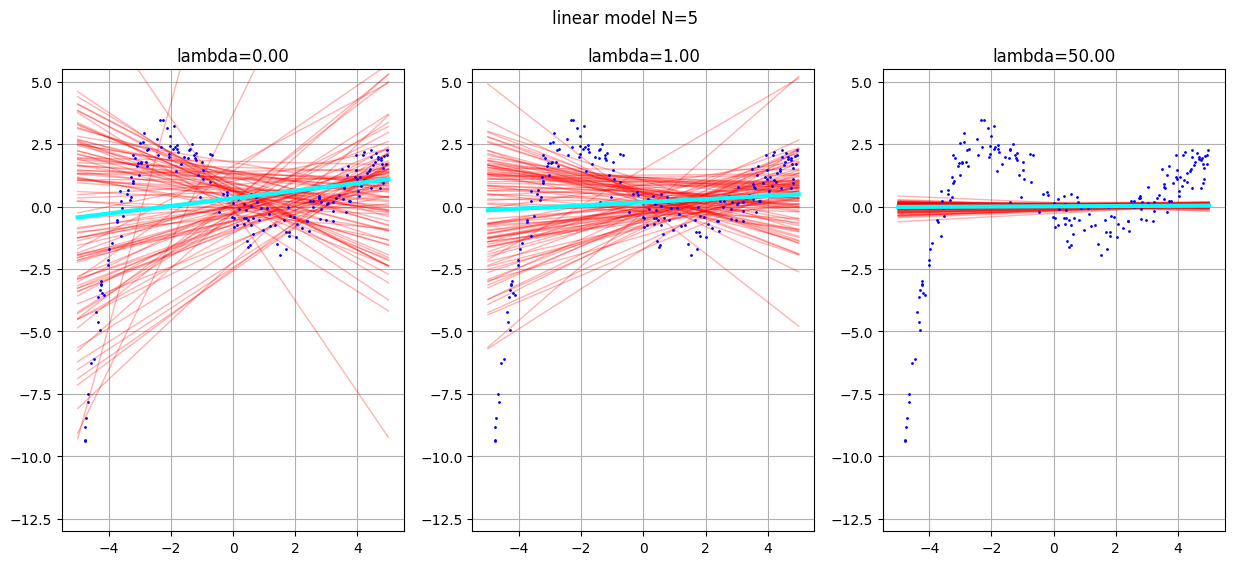

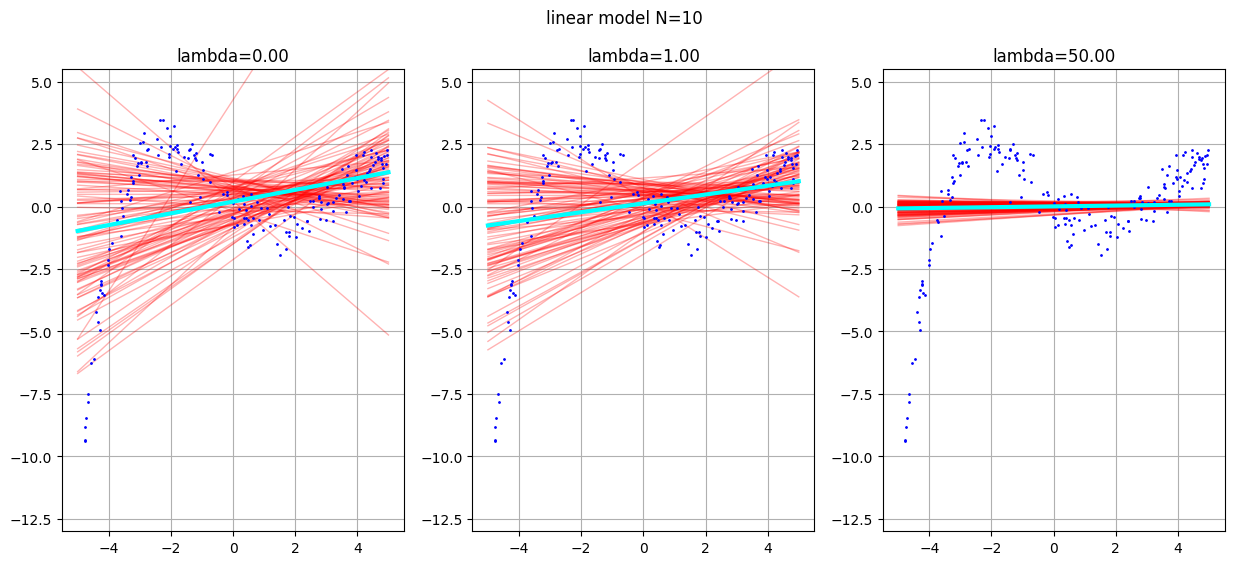

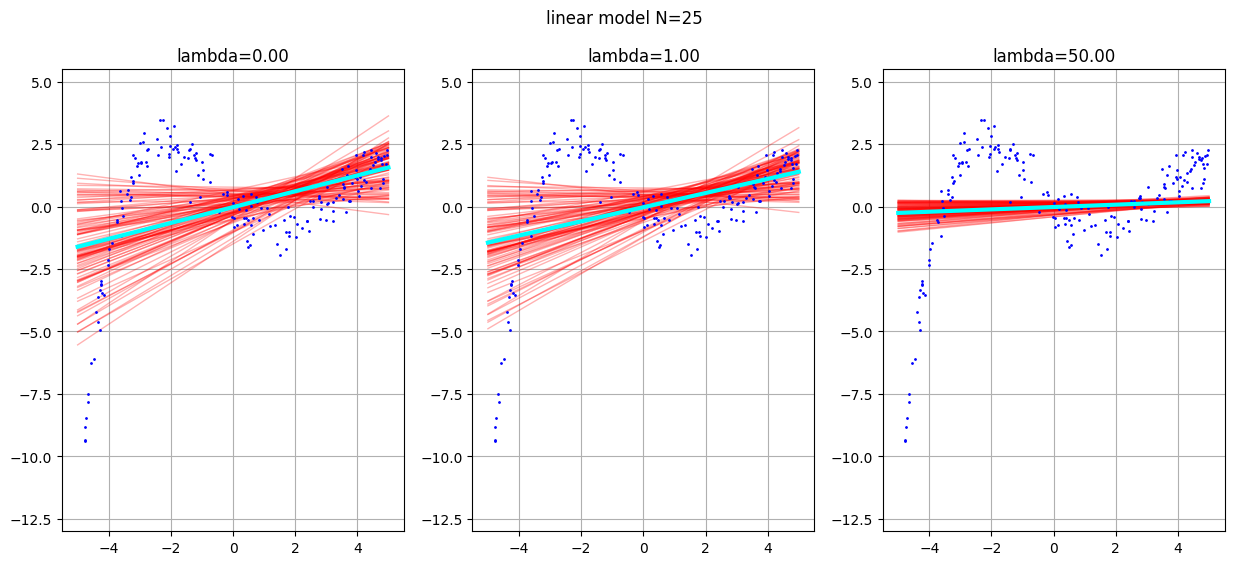

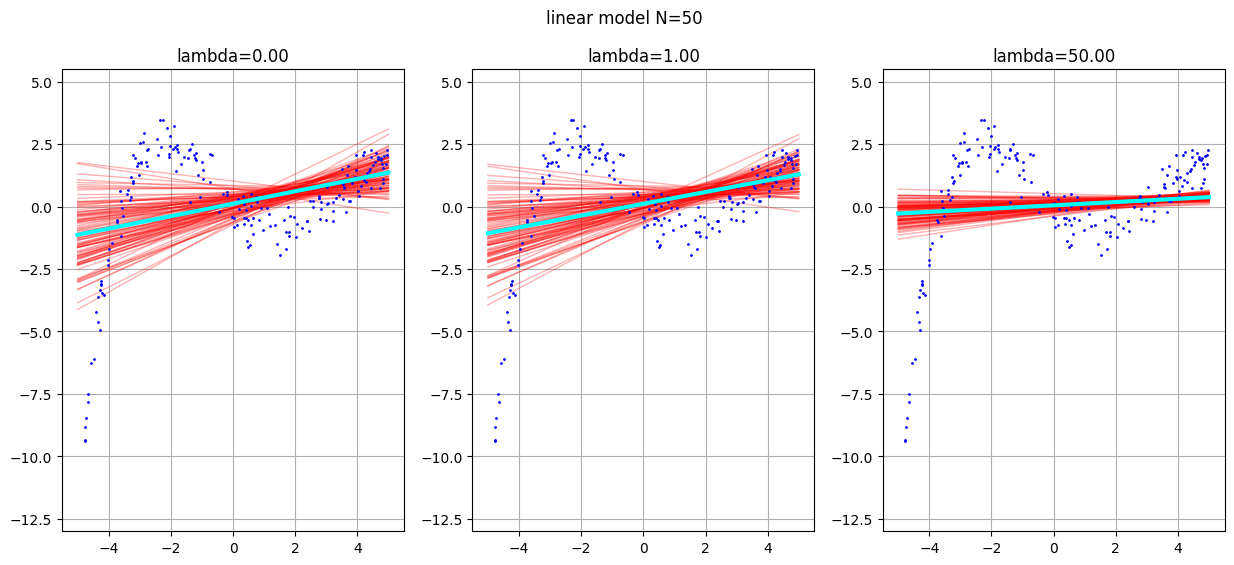

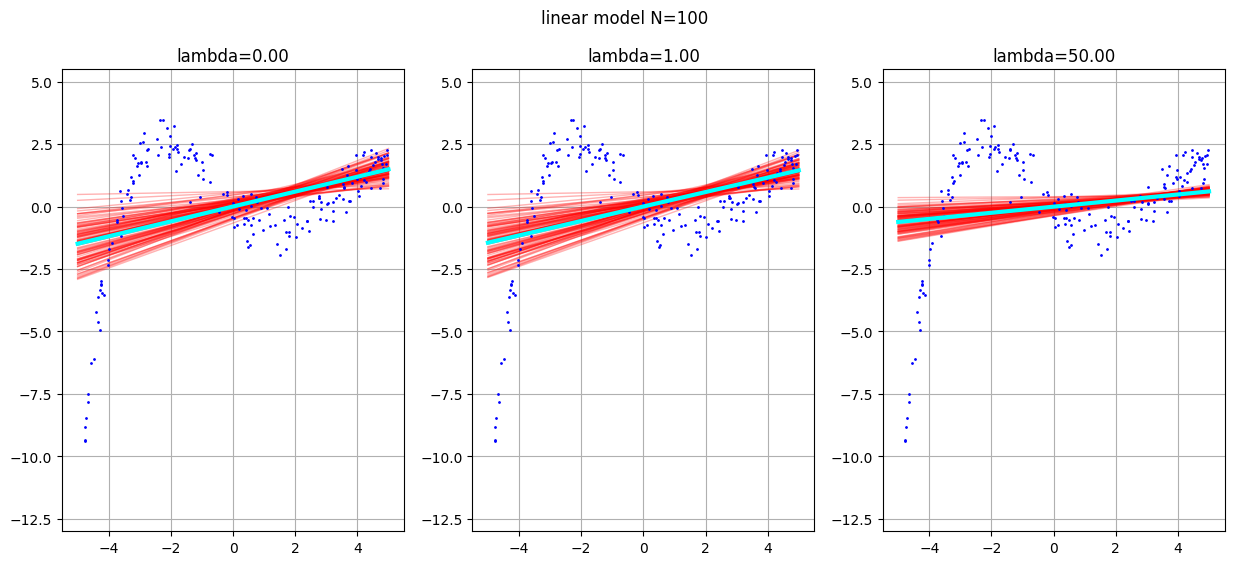

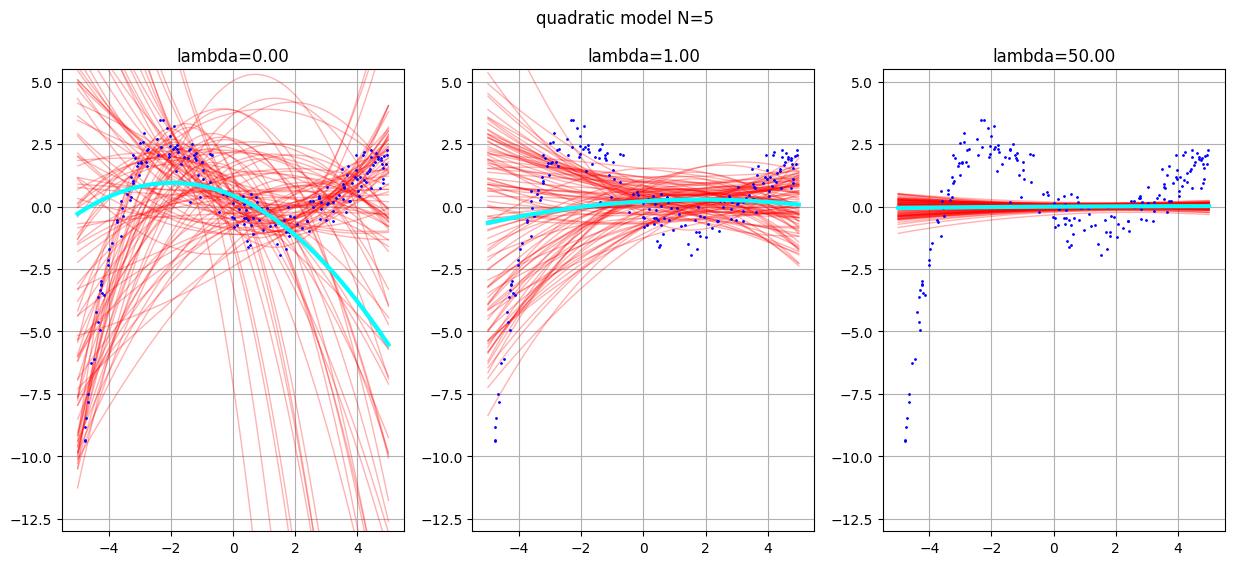

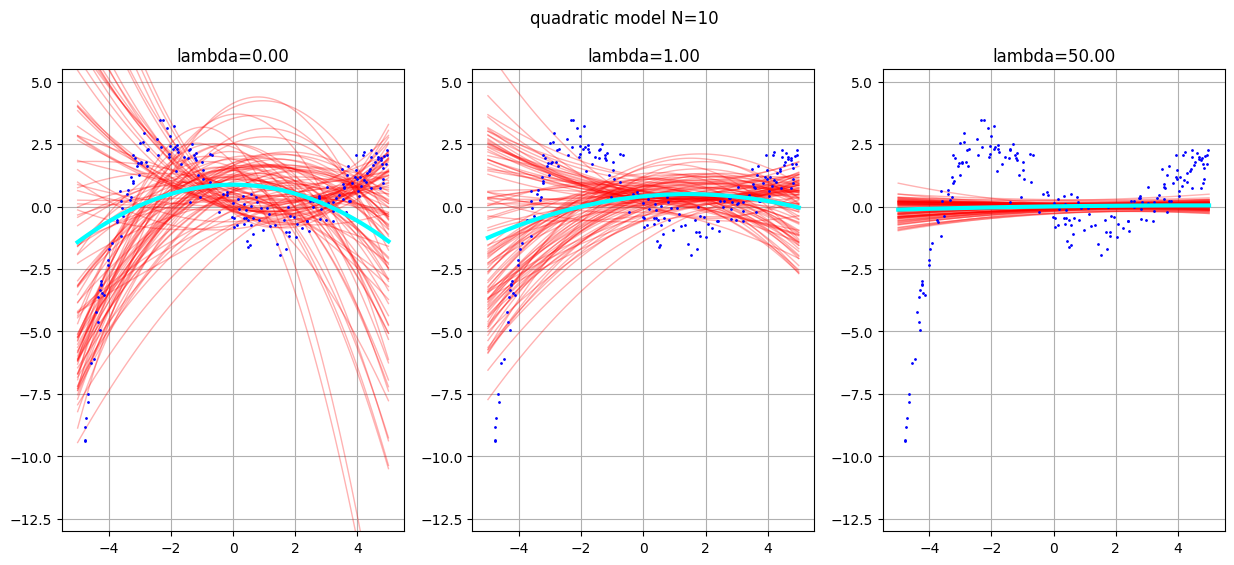

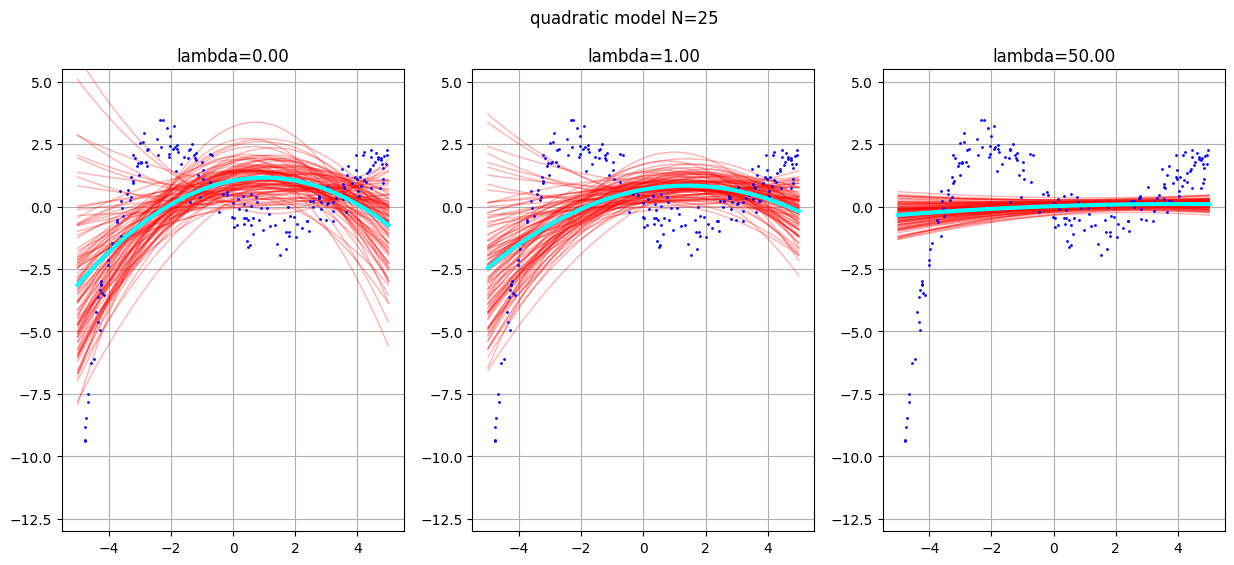

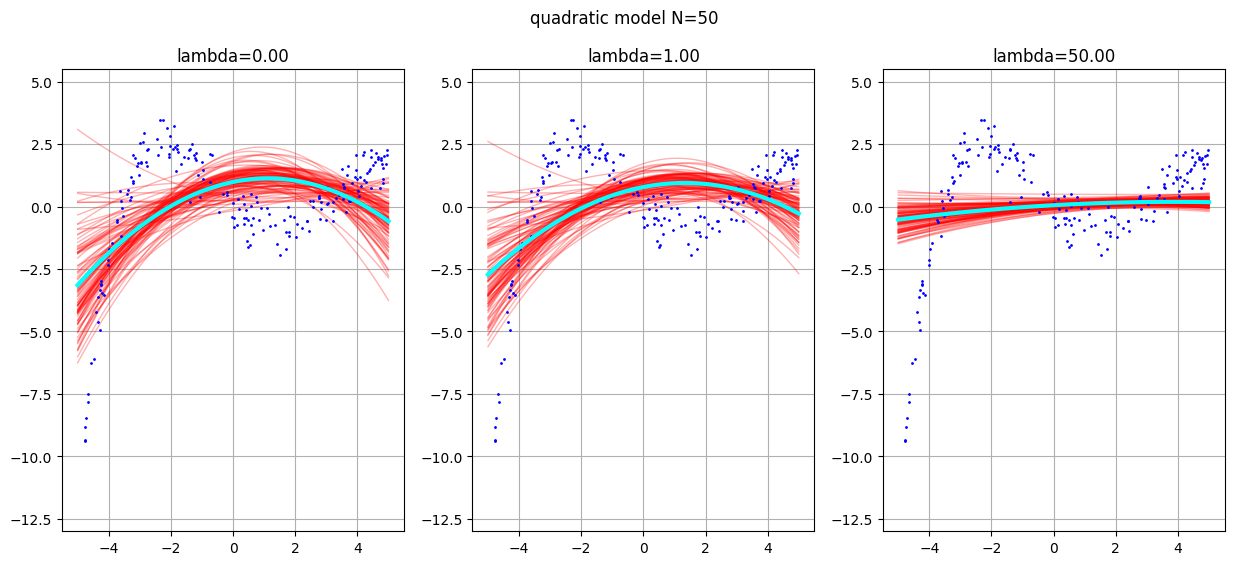

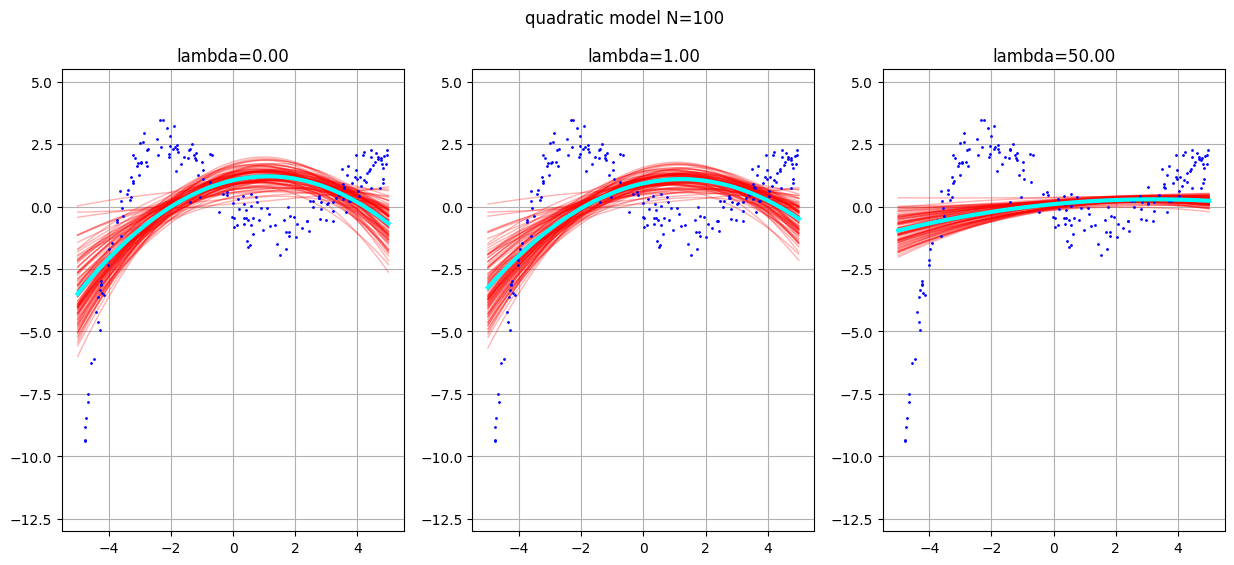

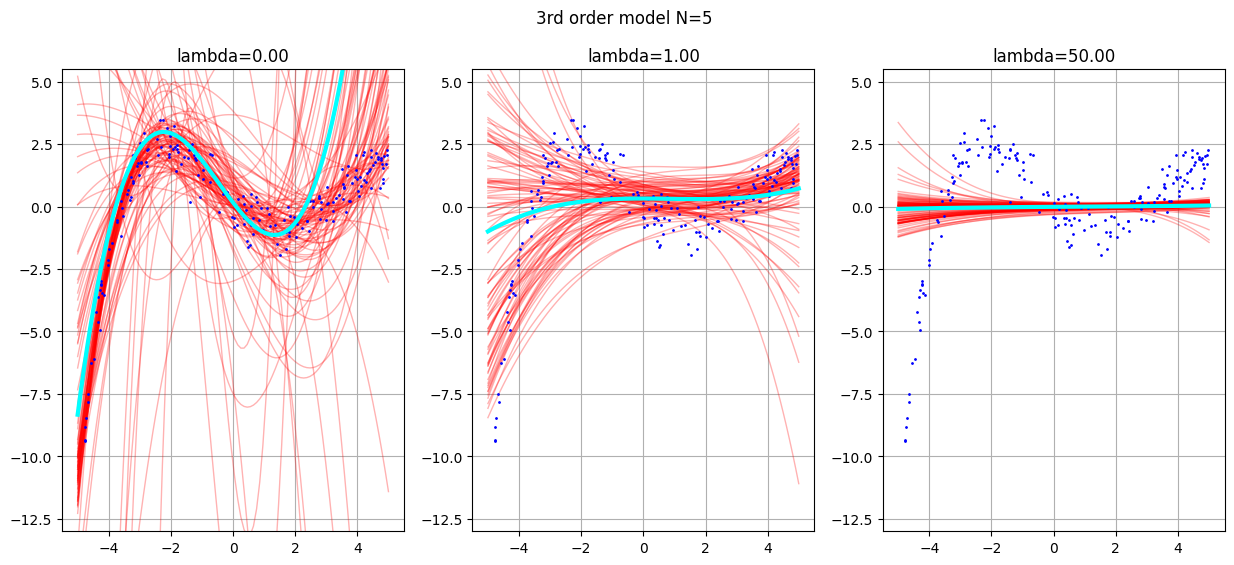

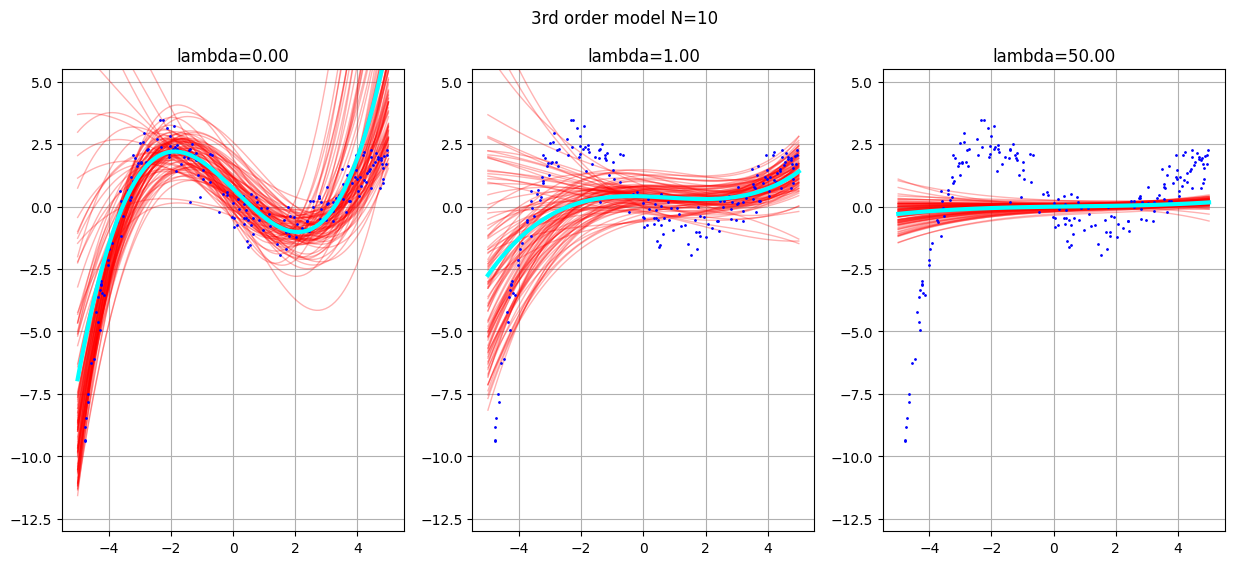

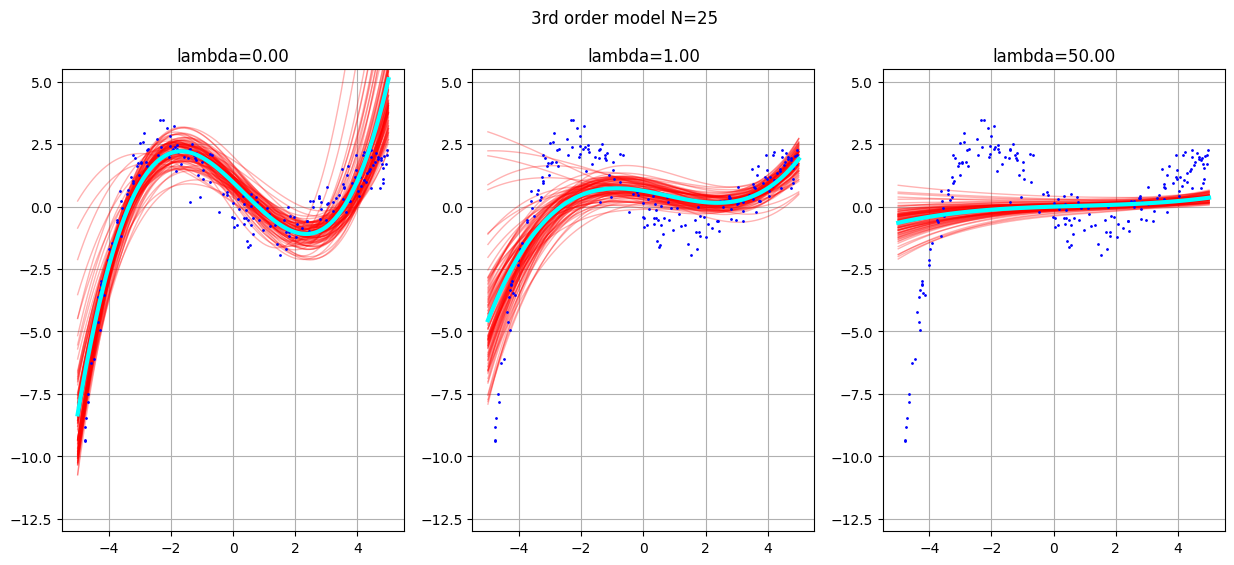

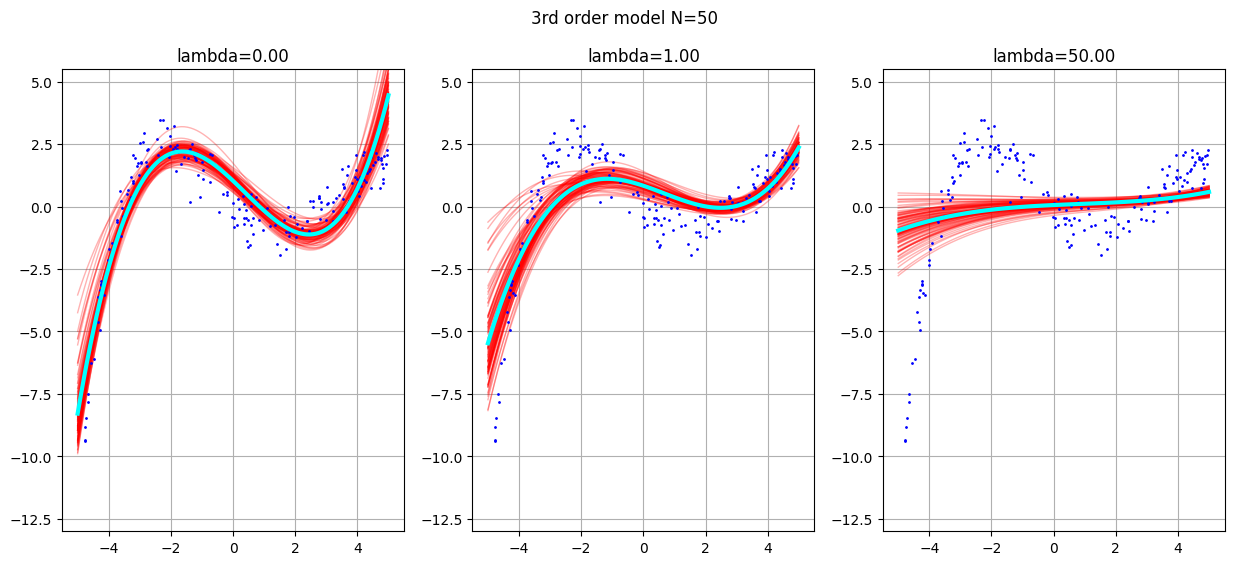

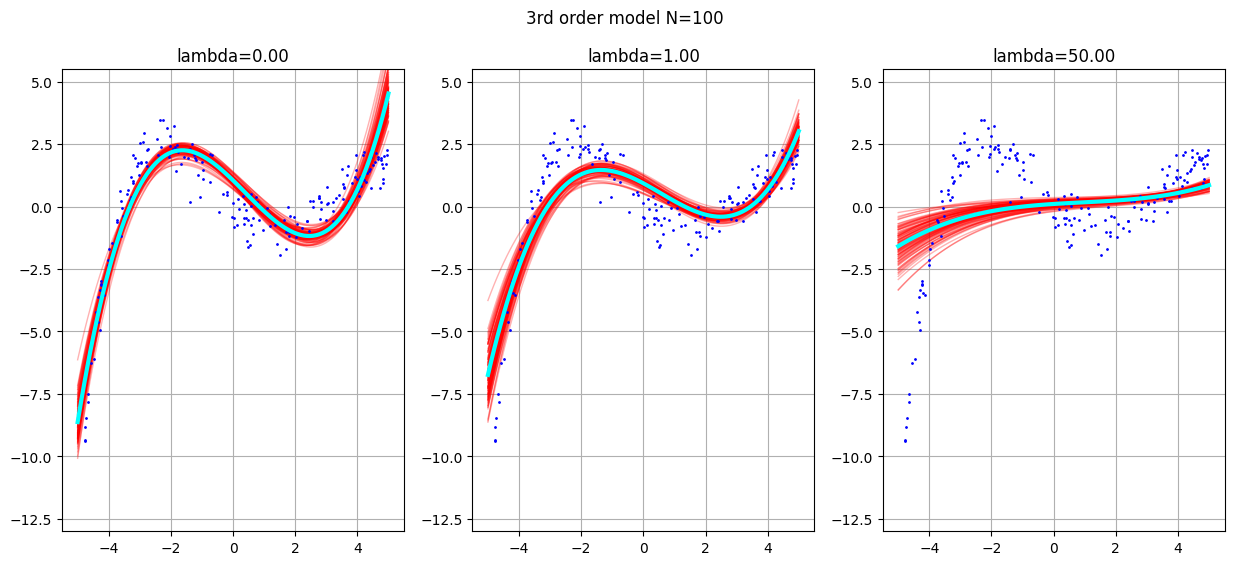

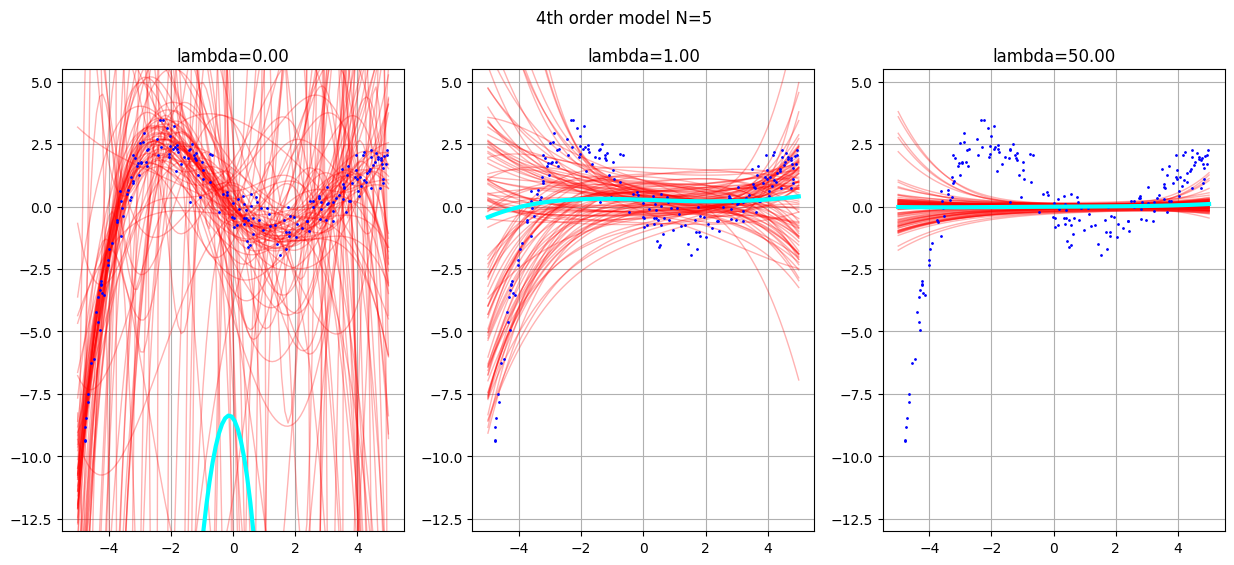

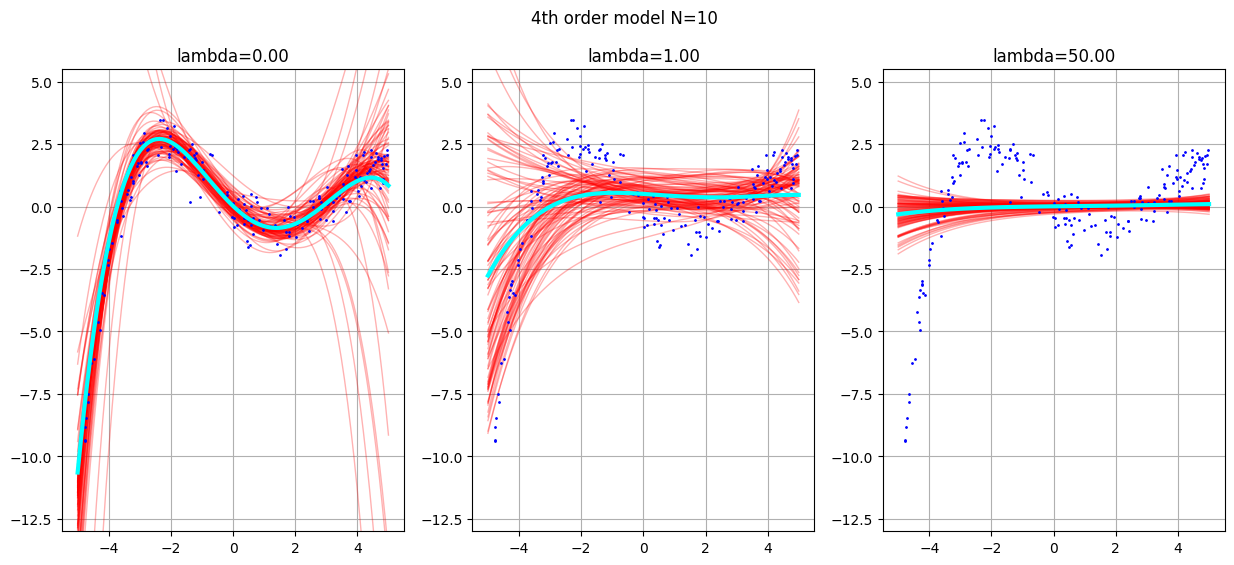

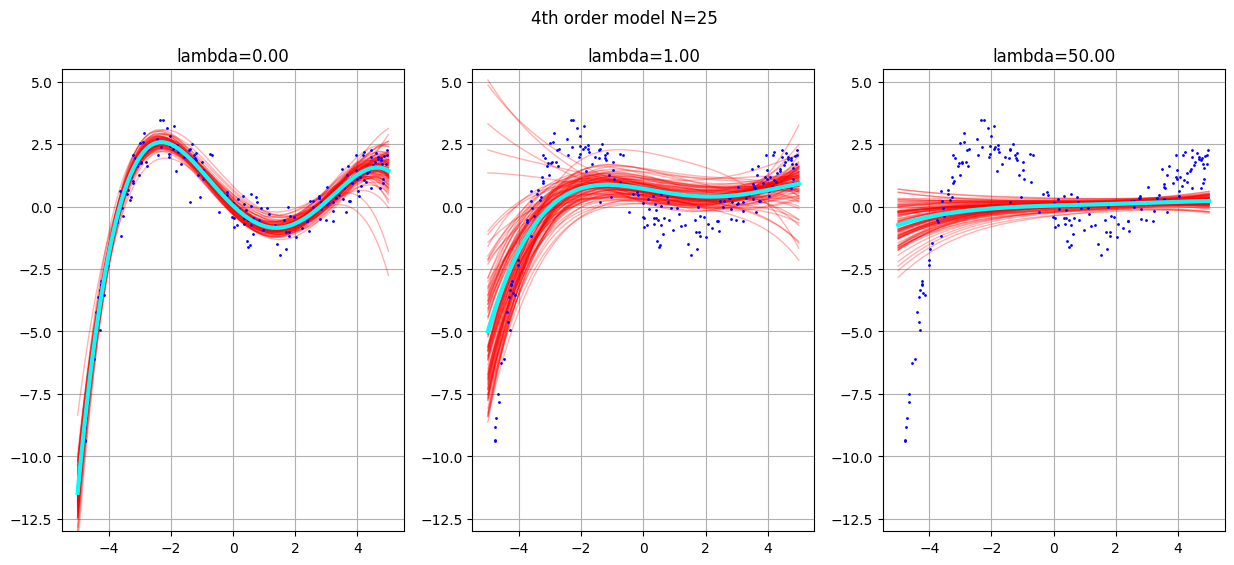

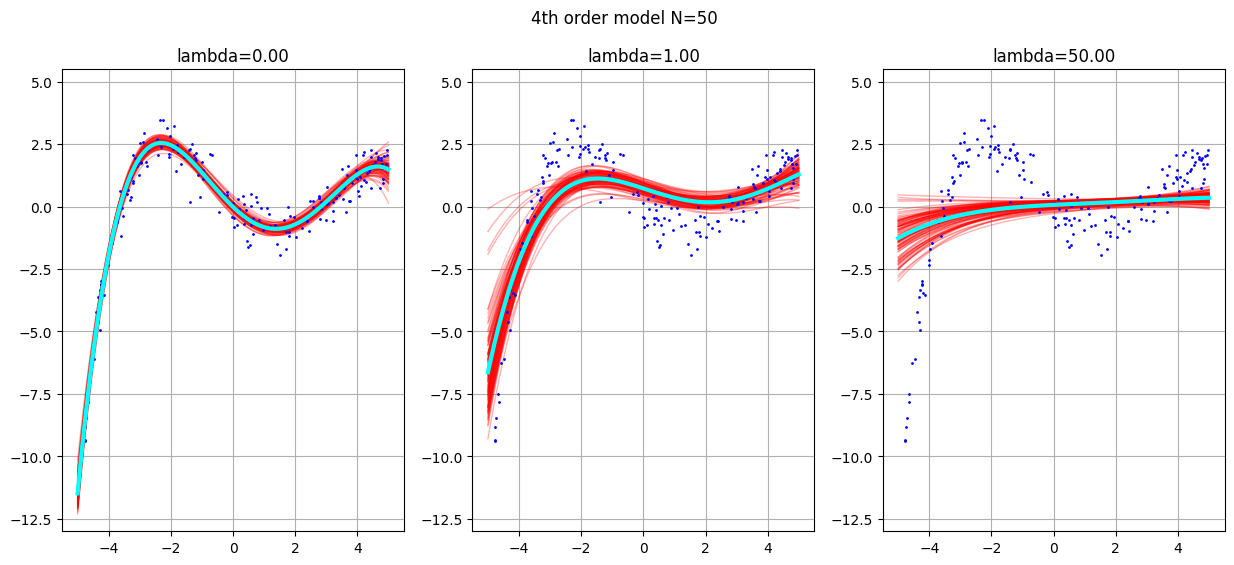

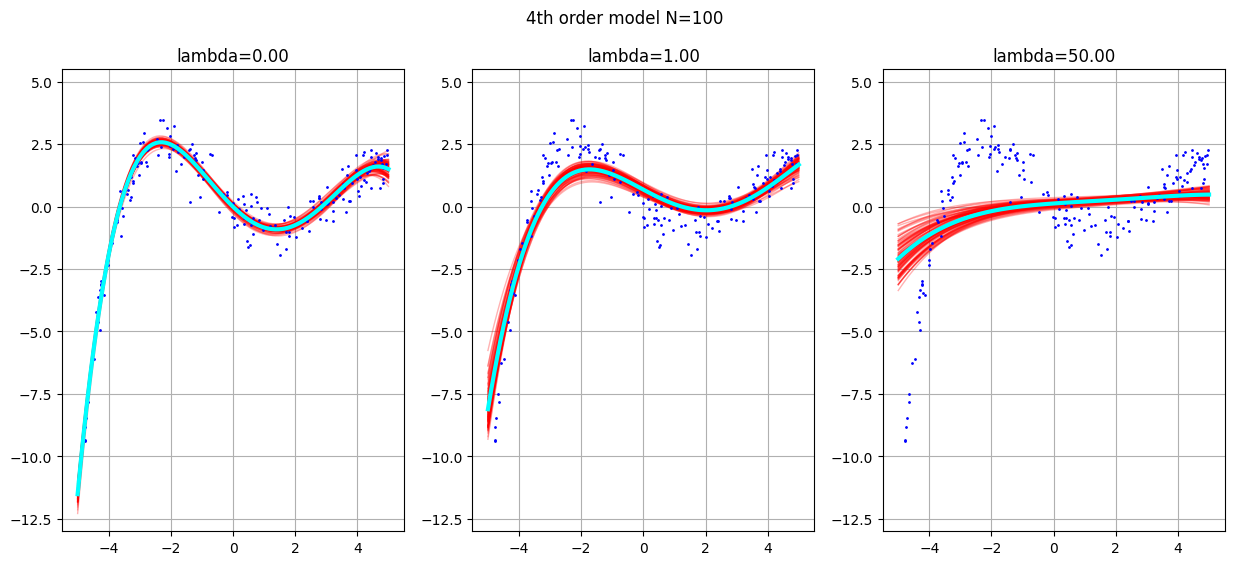

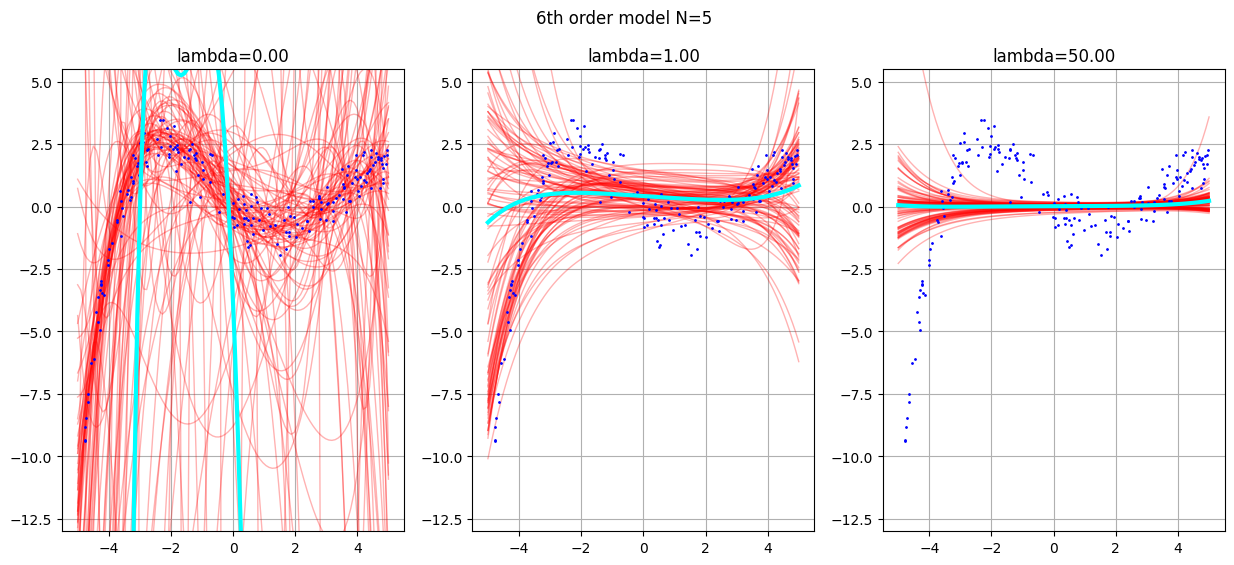

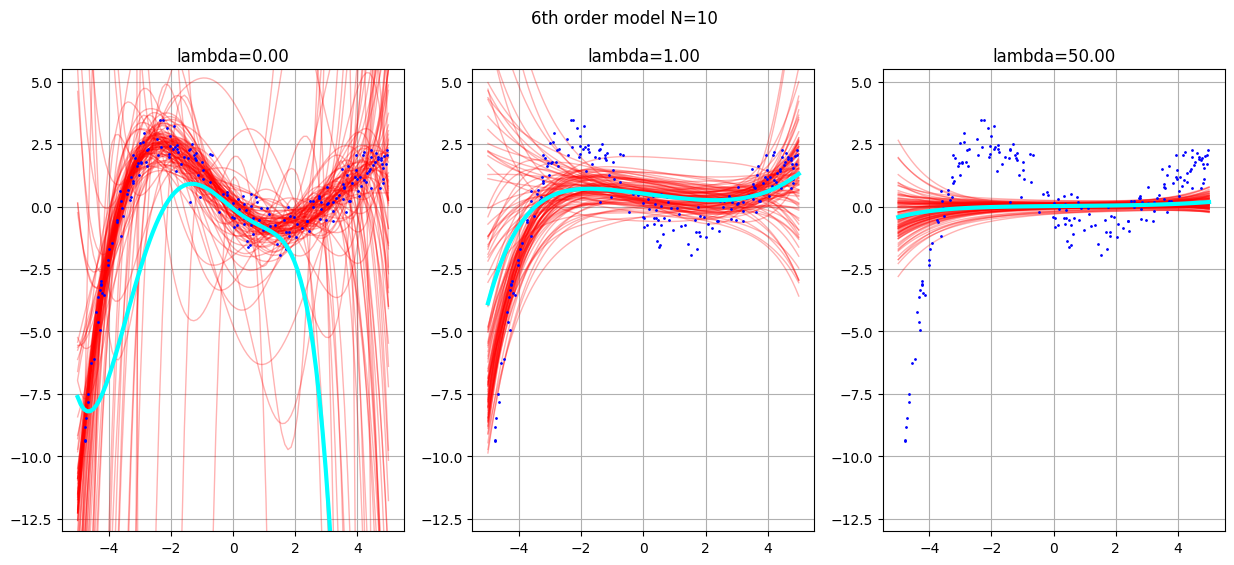

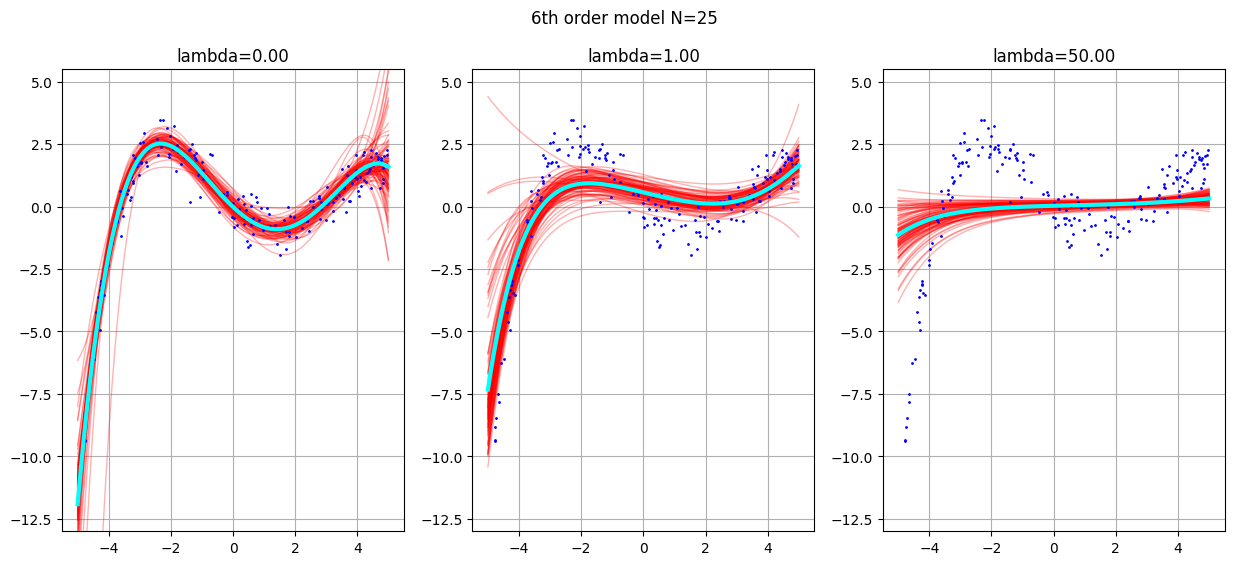

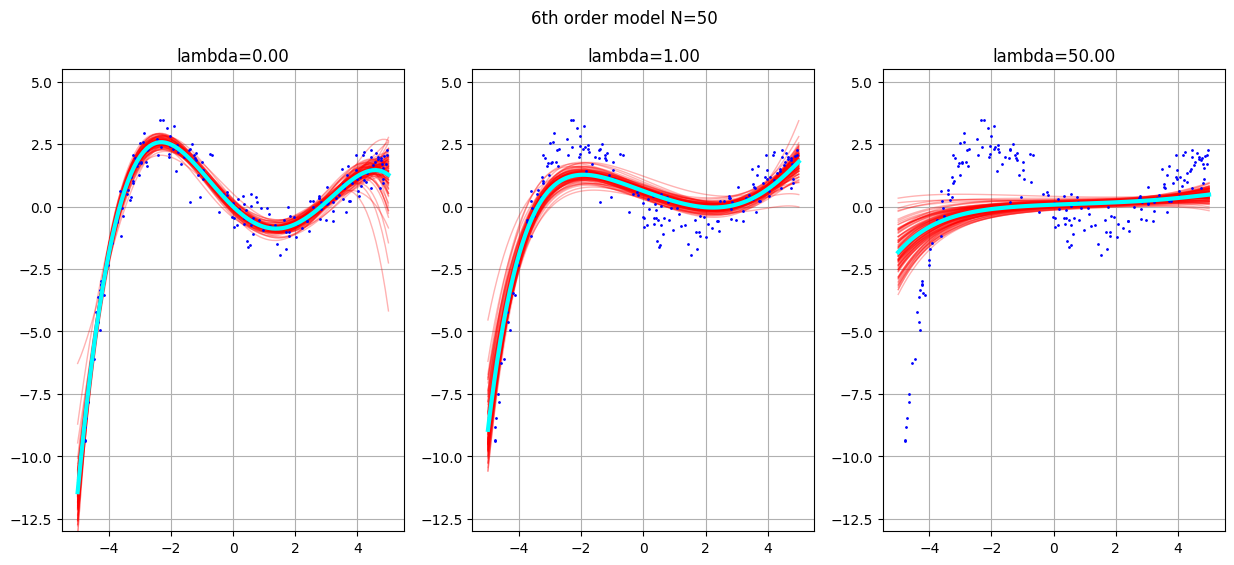

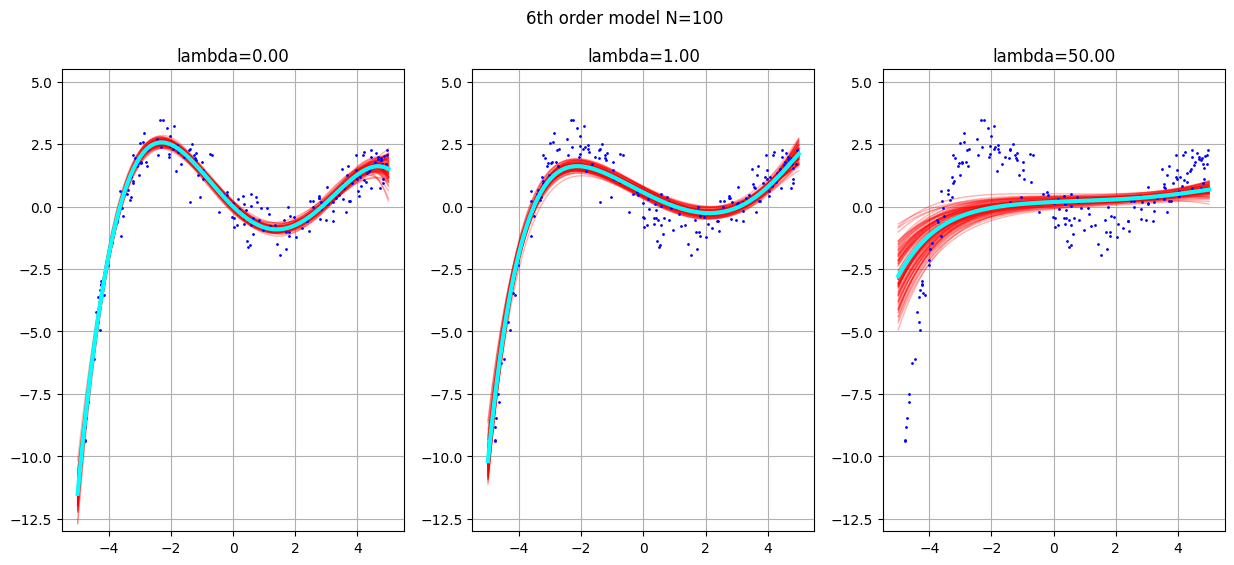

In [6]:
# we will collect all the models fit in these experiments into a dictionary
models=dict()

# this is to make plots more legible
model_names={1: "linear", 2:"quadratic", 3:"3rd order", 4:"4th order",6: "6th order"}

for deg in [1,2,3,4,6]: # for each model type
    for N in Ns: # sample 100 datasets for each N we consider
        train=gen_train_data(fn, num_samples=N, num_sets=100, domain=domain, sigma=sigma)
        # set up the figure
        fig, ax = plt.subplots(1,len(lambdas),figsize=(15,6))
        for l in range (len(lambdas)): 
            # now, for each lambda, fit 100 models of degree d with lambda as the regularization paramter
            # Each model is fit to N datapoints drawn from p(x,y)
            m_index = "N%d, d%d, l%.2f"%(N,deg,lambdas[l]) # string identifying the experiment
            models[m_index]=closed_form_reg_solution(train,lambdas[l],degree=deg) 
            # visualize the models along with a subset of points from p(x,y)
            plot(val[0,:200,:], models[m_index], domain=domain,ax=ax[l])
        fig.suptitle('%s model N=%d'%(model_names[deg],N))

# Error analysis (TO DO)

This is the part you will need to implement; see the Pset for details of what you are asked to do.

In [25]:
# Collaborated with Haichuan Wang

T = 1000
K = 1000
M = 100

val = gen_val_data(fn, num_sets=K, num_samples=T, domain=domain, sigma=sigma) 
xs = np.array([val[0][k][0] for k in range(K)])
x_range = xs.reshape(-1, 1)

for N in Ns:
    train = gen_train_data(fn, num_samples=N, num_sets=M, domain=domain, sigma=sigma)
    for deg in [1,2,3,4,6]:
        for l in range(len(lambdas)):
            models = closed_form_reg_solution(train, lambdas[l], degree=deg)
            f_bar_acc = np.zeros(x_range.shape)
            f_hat_store = [0] * M

            acc_1 = 0 # squared loss
            acc_2 = 0 # noise variance
            acc_3 = 0 # squared bias
            acc_4 = 0 # variance

            for m in range(M):
                x_values, _ = degexpand(x_range, models[m]['deg'], models[m]['C']) # x_value is N x 4, models is vector of 4 (4 is deg)
                f_hat = np.matmul(x_values, models[m]['w']) # f_hat = x_value (N, 4) * w (4, 1) = (N, 1)
                f_bar_acc += f_hat
                f_hat_store[m] = f_hat
                for t in range(T):
                    for k in range(K):
                        acc_1 += (val[t][k][1] - f_hat[t]) ** 2
                        acc_2 += (val[t][k][1] - fn(val[t][k][0])) ** 2

            f_bar = f_bar_acc / M

            for i in range(len(xs)):
                acc_3 += (fn(xs[i]) - f_bar[i]) ** 2
                acc_4 += (f_hat[i] - f_bar[i]) ** 2
                for m in range(M):
                    acc_4 += (f_hat_store[m][i] - f_bar[i]) ** 2
            
            acc_1 = acc_1 / (T*K*M)
            acc_2 = acc_2 / (T*K*M)
            acc_3 = acc_3 / T
            acc_4 = acc_4 / (T*M)
            
            print("N, deg, lambda", N, deg, lambdas[l], "| loss^2, noise^2, bias^2, var^2", acc_1, acc_2, acc_3, acc_4)

N, deg, lambda 5 1 1 | loss^2, noise^2, bias^2, var^2 [7.40889415] 0.25028438944546905 [5.0502264] [1.78064475]
N, deg, lambda 5 2 1 | loss^2, noise^2, bias^2, var^2 [7.48093728] 0.25028438944546905 [5.01324216] [1.90852162]
N, deg, lambda 5 3 1 | loss^2, noise^2, bias^2, var^2 [7.93345877] 0.25028438944546905 [4.60743703] [2.34267981]
N, deg, lambda 5 4 1 | loss^2, noise^2, bias^2, var^2 [8.14584845] 0.25028438944546905 [4.68659478] [2.57824912]


### Observations from graphs
- Increasing N will enhance the fit in all situations, which supports the claim that "N is the best regularizer".
- Regularization is especially important for high-order models. For example, a order-6 model has exceedingly high variance, comparing to a order-2 model. 
- Over regularization is not desierable. That is, when lambda = 50, the high panelty causes the model to be flat, resulting in a poor fit


### Observations from sqr loss
- Total sqr loss can be reduced by regularization. This might due to the small size (200) of our training set. Therefore, a model (especially with high degree) is likely to fit the training set well but generalize poorly on the validation set (size 1000).
- Total sqr loss can also be reduced by N, the size of training set. In all conditions, a larger training set will always result in a better model. 
- Bias and variance and noise add up to total sqr loss. As noise is the same accross all settings, because the data is drawn from a fixed distribution. However, bias and variance show a trade off. When regularization is low, the model is complex, the fit might be good (low bias), but the model is easily influenced by data points, thus reflect a high variance. 

### Finally
- Regularization is important, to prevent a model that fits the training set perfectly but cannot generalize well. 
- A large N is always good, as it redueces the total sqr loss.